# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from script.descriptor import get_acsf_dict,GetRdkitDescriptorsdict,get_fp_dict,get_oh,des_std
from script.model import  models
from sklearn.model_selection import KFold
from script.select_model import get_best_model_and_param
from script.select_feature import feature_selection
from script.utils import get_mix_sol_dict,f_des_std,plot_scatter
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
df=pd.read_csv('./dataset/all_input_data.csv') 
em = df['Anode/Cathode'].to_list()
sol = df['Solvent'].to_list()
ele = df['Electrolyte'].to_list()
cp = df['Current/Potential'].to_list()
labels = np.array(df['Yield (%)'].to_list())
labels_std = np.array(labels)/100

em_set = list(set(em))# one hot
sol_set = list(set(sol))#
ele_set = list(set(ele))#
cp_set = list(set(cp)) # one hot

In [3]:
name2smiles_dict={'nBu4NOAc':"[N+](CCCC)(CCCC)(CCCC)(CCCC).CC(=O)[O-]",
 'NaO2CAd':"CC(=O)[O-].[Na+]",
 'K3PO4':"O=P(O[K])(O[K])[O-].[K+]",
 'LiOAc':'[Li+].CC(=O)[O-]',
 'nBu4NPF6':"[N+](CCCC)(CCCC)(CCCC)(CCCC).[P-](F)(F)(F)(F)F", 
 'NaOAc':'[Na+].CC(=O)[O-]',
 'NaOPiv':"CC(C)(C)C[O-].[Na+]",
 'LiClO4':"O=Cl(=O)([O-])=O.[Li+]",
 'KOAc':'[K+].CC(=O)[O-]',
 'AcOH':'CC(O)=O',
 'EtOH':'CCO',
 'TFE':'FC(F)(CO)F',
 'HFIP':"OC(C(F)(F)F)C(F)(F)F",   
 'MeCN':'CC#N'}
ele_smi=[name2smiles_dict[i] for i in ele]
ele_smi_set=set(ele_smi)
sol_smi_set=['CC(O)=O','CCO','FC(F)(CO)F','CC#N']

# Generate Descriptor

In [4]:
rdkit_ele_dict = GetRdkitDescriptorsdict(ele_smi_set)
rdkit_sol_dict= GetRdkitDescriptorsdict(sol_smi_set)

fp_ele_dict = get_fp_dict(ele_smi_set)
fp_sol_dict= get_fp_dict(sol_smi_set)

em_oh_desc=get_oh(em)
sol_oh_desc=get_oh(sol)
ele_oh_desc=get_oh(ele)
cp_oh_desc=get_oh(cp)

rdkit_sol_all_dict=get_mix_sol_dict(rdkit_sol_dict,sol_set,name2smiles_dict)
fp_sol_all_dict=get_mix_sol_dict(fp_sol_dict,sol_set,name2smiles_dict)

Traceback (most recent call last):
  File "/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/rdkit/Chem/EState/EState.py", line 78, in MaxEStateIndex
    return max(EStateIndices(mol, force))
  File "/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/rdkit/Chem/EState/EState.py", line 48, in EStateIndices
    Is = numpy.zeros(nAtoms, numpy.float)
  File "/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/numpy/__init__.py", line 305, in __getattr__
    raise AttributeError(__former_attrs__[attr])
AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecate

# Chemical Descriptor

In [5]:
#electrolyte
ele_df = np.array(pd.read_excel('descriptor/descriptors of electrolytes.xlsx'))

ele_name_des={}
for i in ele_df:
    ele_name_des[i[0]]=i[1:]
ele_des = np.array([ele_name_des[i] for i in ele],dtype='float64')

#solvents
sol_df = np.array(pd.read_excel('descriptor/descriptors of solvents.xlsx'))
sol_name_des={}
for i in sol_df:
    sol_name_des[i[0]]=i[1:]
sol_des = np.array([sol_name_des[i] for i in sol],dtype='float64')

#em
em_df = np.array(pd.read_excel('descriptor/descriptors of electrodes.xlsx'))
em_name_des={}
for i in em_df:
    em_name_des[i[0]]=i[1:]
em_des = np.array([em_name_des[i] for i in em],dtype='float64')

#cp
cp2onehot = {'0.3 mA':[1,0,0,0,0,0],'0.6 mA':[0,1,0,0,0,0],
             '0.9 mA':[0,0,1,0,0,0],'1.2 mA':[0,0,0,1,0,0],
             '1.0 V':[0,0,0,0,1,0],'1.5 V':[0,0,0,0,0,1]}
cp_des = np.array([cp2onehot[i] for i in cp]).reshape(-1,6)
des = np.concatenate((ele_des,sol_des,em_des,cp_des),axis=1)
cd_new_std = f_des_std(des)

# Generate Reaction Feature

In [6]:
num=len(em)

rdkit_total_ele = np.array([[rdkit_ele_dict[tmp_smi]] for tmp_smi in ele_smi]).reshape(num,-1)
rdkit_total_sol = np.array([[rdkit_sol_all_dict[tmp_smi]] for tmp_smi in sol]).reshape(num,-1)
rdkit_react_feat = np.concatenate([em_oh_desc,rdkit_total_ele,rdkit_total_sol,cp_oh_desc],axis = 1)
rdkit_react_feat_std=f_des_std(rdkit_react_feat)

fp_total_ele = np.array([[fp_ele_dict[tmp_smi]] for tmp_smi in ele_smi]).reshape(num,-1)
fp_total_sol = np.array([[fp_sol_all_dict[tmp_smi]] for tmp_smi in sol]).reshape(num,-1)
fp_react_feat = np.concatenate([em_oh_desc,fp_total_ele,fp_total_sol,cp_oh_desc],axis = 1)
fp_react_feat_std=f_des_std(fp_react_feat)

oh_react_feat = np.concatenate([em_oh_desc,sol_oh_desc,ele_oh_desc,cp_oh_desc],axis = 1)
oh_react_feat_std=f_des_std(oh_react_feat)

# Model Selection

In [14]:
input_index=list(range(len(cd_new_std)))
best_model_name,best_model_params,best_params=get_best_model_and_param(cd_new_std,labels_std,input_index)# Socre: -MAE

Model:   BG, Best Socre: -0.0914, Best Param:  {'n_estimators': 100}
Model:   DT, Best Socre: -0.1113, Best Param:  {'max_depth': None}
Model:   ET, Best Socre: -0.0895, Best Param:  {'max_depth': 10, 'n_estimators': 300}
Model:   GB, Best Socre: -0.0910, Best Param:  {'max_depth': 3, 'n_estimators': 50}
Model:  KNR, Best Socre: -0.0996, Best Param:  {'n_neighbors': 4}
Model:  KRR, Best Socre: -0.1029, Best Param:  {'gamma': None}


/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hx-gpu3/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to 

Model: LSVR, Best Socre: -0.1088, Best Param:  {'C': 5, 'epsilon': 0.0}
Model:   RF, Best Socre: -0.0912, Best Param:  {'max_depth': None, 'n_estimators': 100}
Model: Ridge, Best Socre: -0.1016, Best Param:  {'alpha': 1.5}
Model:  SVR, Best Socre: -0.0872, Best Param:  {'gamma': 'scale', 'kernel': 'poly'}
Model:  XGB, Best Socre: -0.0966, Best Param:  {'max_depth': 20}
Best Model:  SVR, Best Param:  {'gamma': 'scale', 'kernel': 'poly'}


# Feature Selection

In [15]:
Feature_selection = feature_selection(model_name=best_model_name,
                    input_index=input_index,des_std=cd_new_std,yield_std=labels_std,best_params=best_params)
print('Model: %5s, Index of feature: %s, Pearson R: %.4f'%(best_model_name,
                str(Feature_selection.selected_feature),Feature_selection.pear))

[18, 29, 7, 30, 0, 33, 11, 14, 12, 6, 13, 34, 17, 21]
Model:   SVR, Index of feature: [18, 29, 7, 30, 0, 33, 11, 14, 12, 6, 13, 34, 17, 21], Pearson R: 0.8652


In [9]:
CD_sel=[18, 29, 7, 30, 0, 33, 11, 14, 12, 6, 13, 34, 17, 21]
descs = [oh_react_feat_std,rdkit_react_feat_std,fp_react_feat_std,cd_new_std[:,CD_sel]]
model_names = ['BG','DT','ET','GB','KNR','KRR','LSVR','RF','Ridge','SVR','XGB']
desc_names = ['OH','Rdkit','MF','CD']

# Results of Regression Prediction

In [10]:
kfold = KFold(n_splits=5,shuffle=True)
performance_dict = {}
for model,model_name in zip(models,model_names):
    for desc,desc_name in zip(descs,desc_names): 
        all_r2 = []
        all_pearsr = []
        all_mae = []
        all_rmse= []
        repeat_pred = []
        repeat_test = []
        np.random.seed(53)
        desc[np.where(np.isnan(desc)==True)]=0
        for i in range(1):  
            tem_pred = []
            tem_test = []            
            for train_index,val_index in kfold.split(desc):
                train_x,test_x = desc[train_index],desc[val_index]
                train_y,test_y = labels_std[train_index],labels_std[val_index]
                model.fit(train_x,train_y)
                test_pred = model.predict(test_x)*(labels.max()-labels.min())+labels.min()
                test_y=test_y*(labels.max()-labels.min())+labels.min()
                tem_pred.append(test_pred)
                tem_test.append(test_y)
            tem_pred = np.concatenate(tem_pred)
            tem_test = np.concatenate(tem_test)
            repeat_pred.append(tem_pred)
            repeat_test.append(tem_test)            
            r2 = r2_score(tem_test,tem_pred)
            pearsr = pearsonr(tem_test,tem_pred)
            mae = mean_absolute_error(tem_test,tem_pred)
            rmse=(mean_squared_error(tem_test,tem_pred))**(0.5)
            all_r2.append(r2)
            all_pearsr.append(pearsr[0])
            all_mae.append(mae)
            all_rmse.append(rmse)
        performance_dict['%s-%s'%(model_name,desc_name)] = [np.mean(all_r2),np.mean(all_pearsr),np.mean(all_mae),
                                                            np.mean(all_rmse),repeat_pred[np.argmax(all_r2)],repeat_test[np.argmax(all_r2)]]
        print('Model: %5s, Descriptor: %15s: R2: %.4f, MAE: %.4f, RMSE: %.4f, Pearson R: %.4f'%(
        model_name,desc_name,np.mean(all_r2),np.mean(all_mae),np.mean(all_rmse),np.mean(all_pearsr)))

Model:    BG, Descriptor:              OH: R2: 0.5302, MAE: 6.3463, RMSE: 8.9149, Pearson R: 0.7658
Model:    BG, Descriptor:           Rdkit: R2: 0.5183, MAE: 6.3206, RMSE: 9.0269, Pearson R: 0.7632
Model:    BG, Descriptor:              MF: R2: 0.5465, MAE: 6.2321, RMSE: 8.7586, Pearson R: 0.7627
Model:    BG, Descriptor:              CD: R2: 0.5181, MAE: 6.6851, RMSE: 9.0284, Pearson R: 0.7452
Model:    DT, Descriptor:              OH: R2: 0.2819, MAE: 8.5029, RMSE: 11.0216, Pearson R: 0.6893
Model:    DT, Descriptor:           Rdkit: R2: 0.1498, MAE: 8.9250, RMSE: 11.9926, Pearson R: 0.6040
Model:    DT, Descriptor:              MF: R2: 0.3659, MAE: 7.2985, RMSE: 10.3566, Pearson R: 0.6976
Model:    DT, Descriptor:              CD: R2: 0.2527, MAE: 8.0809, RMSE: 11.2433, Pearson R: 0.6223
Model:    ET, Descriptor:              OH: R2: 0.3265, MAE: 7.9014, RMSE: 10.6736, Pearson R: 0.7097
Model:    ET, Descriptor:           Rdkit: R2: 0.3488, MAE: 7.3674, RMSE: 10.4958, Pearson R: 0

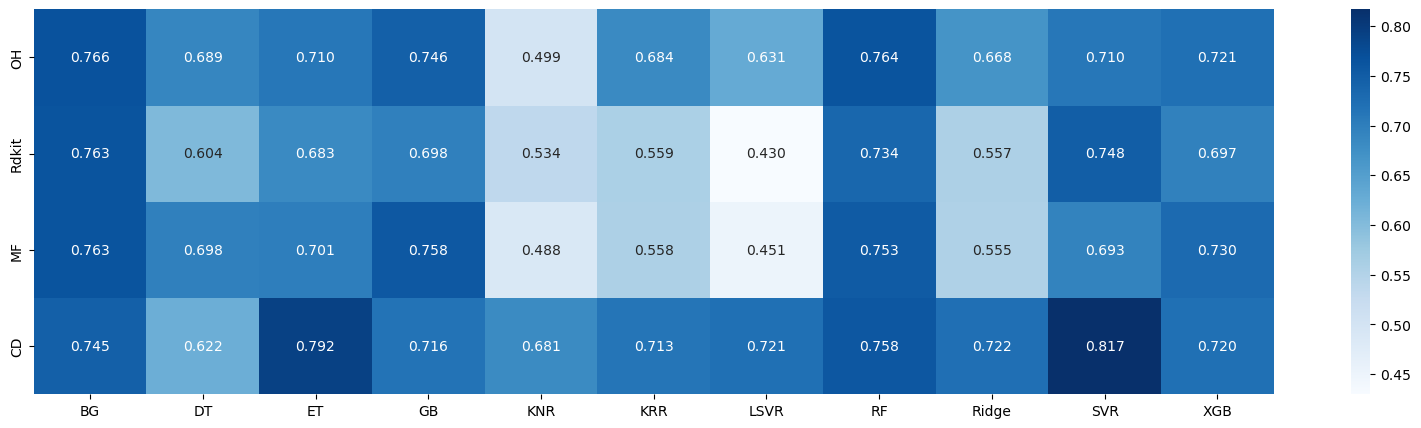

In [11]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][1]
fig = plt.figure(figsize=(20,5))
sns.heatmap(r2_map,annot=True,fmt='.3f',xticklabels=model_names,yticklabels=desc_names,cmap='Blues')
plt.show()

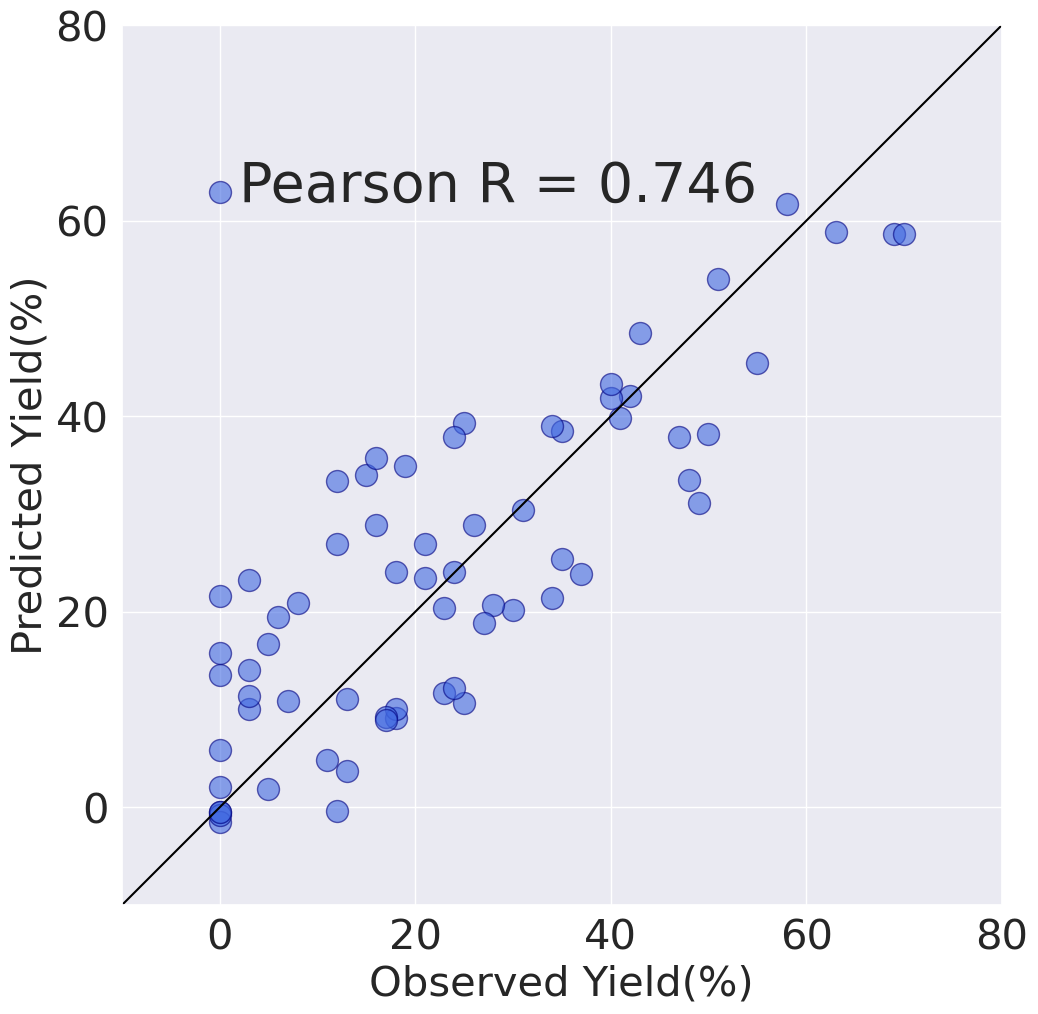

In [39]:
plot_scatter(performance_dict,'GB-OH')

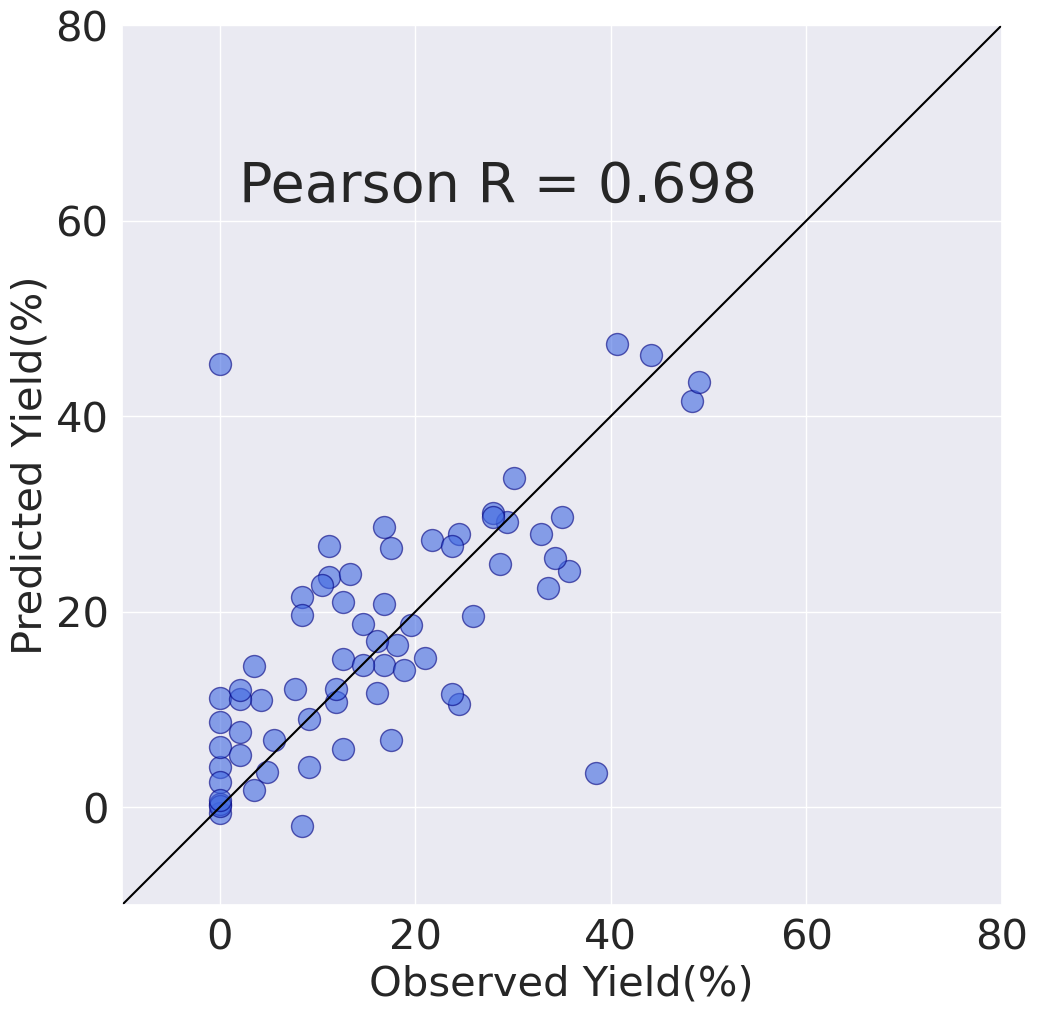

In [17]:
plot_scatter(performance_dict,'GB-Rdkit')

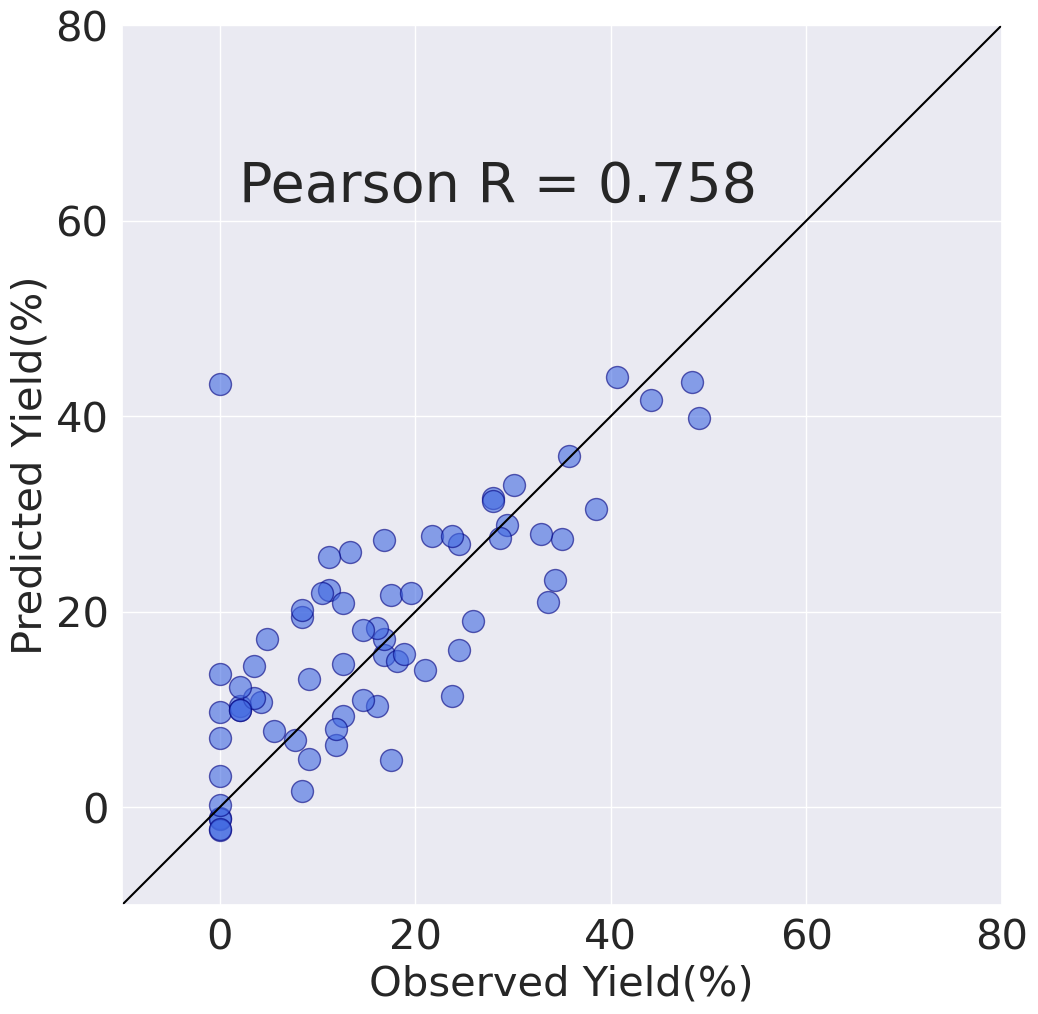

In [18]:
plot_scatter(performance_dict,'GB-MF')

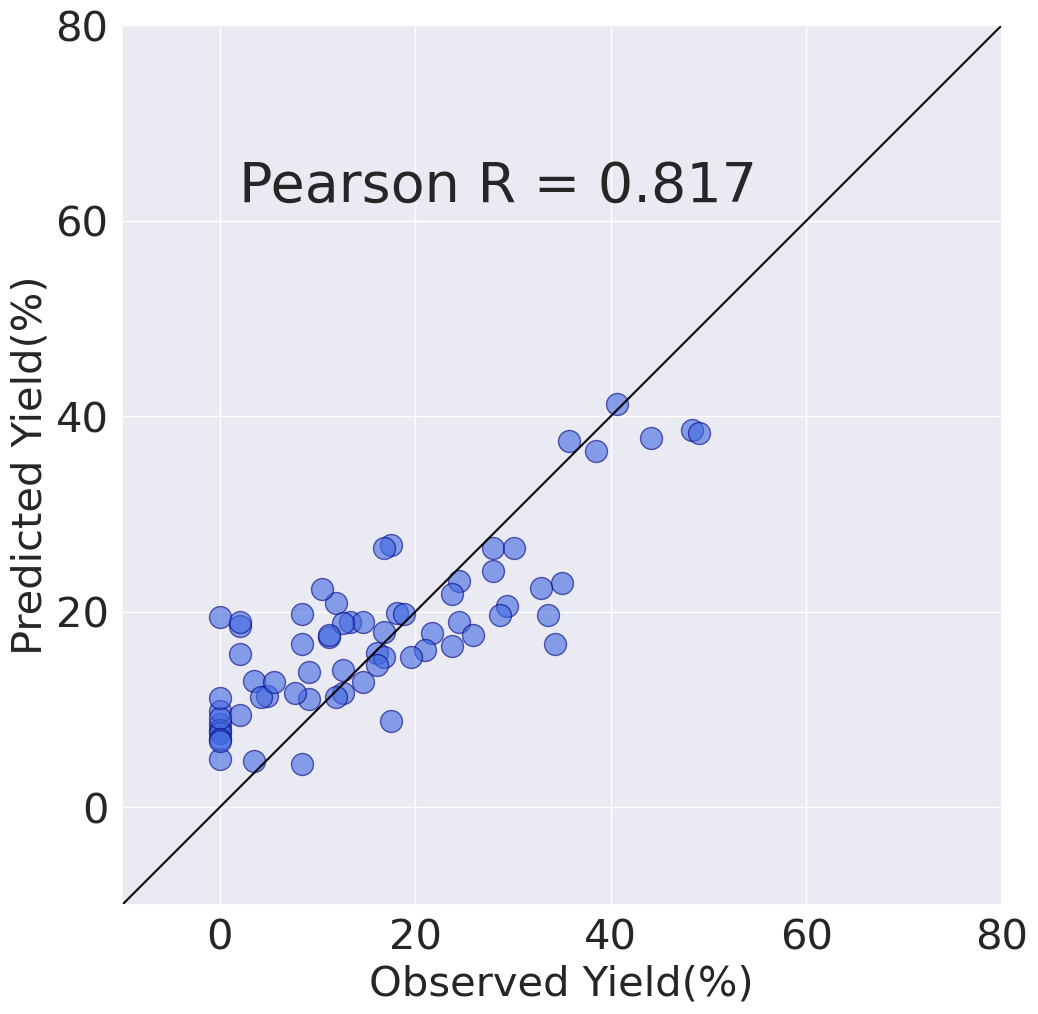

In [20]:
plot_scatter(performance_dict,'SVR-CD')

# Results of Extrapolated Regression Prediction

In [202]:
train_index=[]
val_index=[]
for index,i in enumerate(np.array(df)):
    if i[5]<50:
        train_index.append(index)
    else:
        val_index.append(index)
print(len(val_index),len(train_index))

7 61


In [159]:
performance_dict = {}
for model,model_name in zip(models,model_names):
    for desc,desc_name in zip(descs,desc_names): 
        all_r2 = []
        all_pearsr = []
        all_mae = []
        all_rmse= []
        repeat_pred = []
        repeat_test = []
        for i in range(1):            
            train_x,test_x = desc[train_index],desc[val_index]
            train_y,test_y = labels_std[train_index],labels_std[val_index]
            model.fit(train_x,train_y)
            test_pred = model.predict(test_x)
            test_y=test_y
            repeat_pred.append(test_pred)
            repeat_test.append(test_y)
            r2 = r2_score(test_y,test_pred)
            pearsr = pearsonr(test_y,test_pred)
            mae = mean_absolute_error(test_y,test_pred)
            rmse=(mean_squared_error(test_y,test_pred))**(0.5)
            all_r2.append(r2)
            all_pearsr.append(pearsr[0])
            all_mae.append(mae)
            all_rmse.append(rmse)
        performance_dict['%s-%s'%(model_name,desc_name)] = [np.mean(all_r2),np.mean(all_pearsr),np.mean(all_mae),
                                                            np.mean(all_rmse),repeat_pred[np.argmax(all_r2)],repeat_test[np.argmax(all_r2)]]
        print('Model: %5s, Descriptor: %15s: R2: %.4f, MAE: %.4f, RMSE: %.4f, Pearson R: %.4f'%(
        model_name,desc_name,np.mean(all_r2),np.mean(all_mae),np.mean(all_rmse),np.mean(all_pearsr)))

Model:    BG, Descriptor:              OH: R2: -15.7377, MAE: 0.2897, RMSE: 0.3084, Pearson R: 0.1444
Model:    BG, Descriptor:           Rdkit: R2: -14.5773, MAE: 0.2747, RMSE: 0.2975, Pearson R: 0.3214
Model:    BG, Descriptor:              MF: R2: -17.8701, MAE: 0.3170, RMSE: 0.3274, Pearson R: 0.3693
Model:    BG, Descriptor:          CD_New: R2: -11.8170, MAE: 0.2551, RMSE: 0.2699, Pearson R: 0.4426
Model:    DT, Descriptor:              OH: R2: -10.3901, MAE: 0.2086, RMSE: 0.2544, Pearson R: 0.3213
Model:    DT, Descriptor:           Rdkit: R2: -13.2087, MAE: 0.2471, RMSE: 0.2841, Pearson R: 0.2201
Model:    DT, Descriptor:              MF: R2: -11.5568, MAE: 0.2314, RMSE: 0.2671, Pearson R: 0.3560
Model:    DT, Descriptor:          CD_New: R2: -15.7381, MAE: 0.2786, RMSE: 0.3084, Pearson R: 0.3719
Model:    ET, Descriptor:              OH: R2: -11.9410, MAE: 0.2339, RMSE: 0.2712, Pearson R: 0.2869
Model:    ET, Descriptor:           Rdkit: R2: -12.6745, MAE: 0.2443, RMSE: 0.2787

<Axes: >

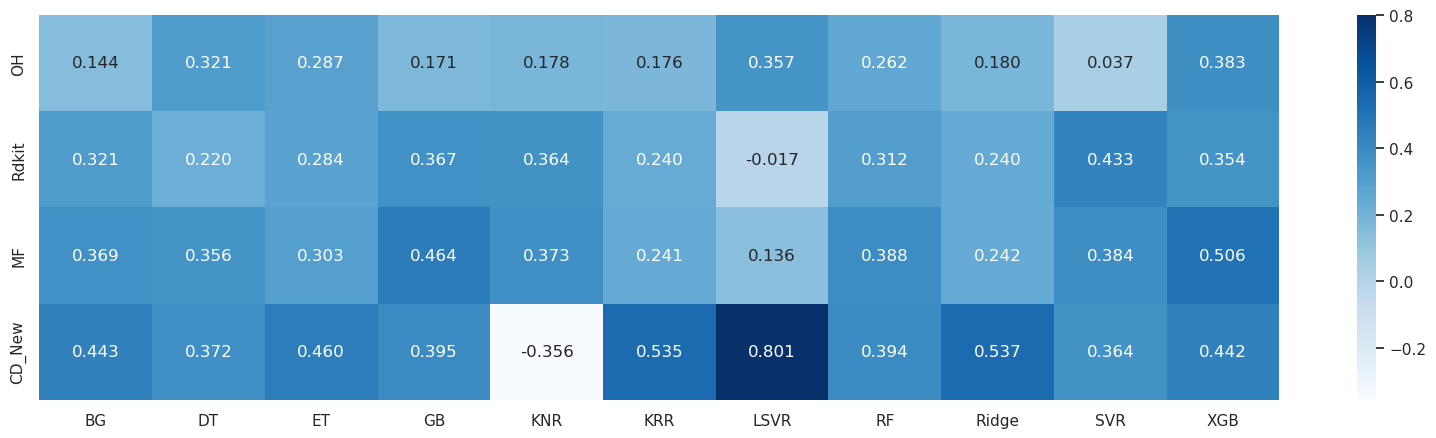

In [160]:
#seed=1
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][1]
fig = plt.figure(figsize=(20,5))
sns.heatmap(r2_map,annot=True,fmt='.3f',xticklabels=model_names,yticklabels=desc_names,cmap='Blues')